In [2]:
import os
import cv2
import numpy as np
from keras import layers
import matplotlib.pyplot as plt
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D
from keras.layers import BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers import SeparableConv2D, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [36]:

from keras.preprocessing import image
import os, imageio
from glob import glob
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import keras.backend as K

In [3]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model

In [4]:
from google.colab import drive
drive.mount('/Xception')

Drive already mounted at /Xception; to attempt to forcibly remount, call drive.mount("/Xception", force_remount=True).


In [5]:
def entry_flow(inputs):

  #padding='same' means size of fearure map is same of output feature map
  x=Conv2D(
      filters=32,kernel_size=(3,3),strides=(2,2),padding='same' )(inputs)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=Conv2D(
      filters=64,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  previous_block_input=x
  print('entry_flow')
  for size in [128,256,728]:
    
    #the SeparableConv2D is a variation of the traditional convolution that was proposed 
    #to compute it faster. It performs a depthwise spatial convolution followed by a pointwise
    #convolution which mixes together the resulting output channels
    x=Activation('relu')(x)
    x=SeparableConv2D(
        filters=size,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=Activation('relu')(x)
    #https://stackoverflow.com/questions/54705367/what-is-the-difference-between-separableconv2d-and-conv2d-layers
    x=SeparableConv2D(
        filters=size,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

    resnet_x=Conv2D(filters=size,kernel_size=(1,1),strides=(2,2),padding='same')(previous_block_input)
    x=Add()([x,resnet_x])
    previous_block_input=x
  return x


In [6]:
########  call the entry_flow function
input = Input(shape=(224, 224, 3))
model=entry_flow(input)
print(model)

entry_flow
KerasTensor(type_spec=TensorSpec(shape=(None, 14, 14, 728), dtype=tf.float32, name=None), name='add_2/add:0', description="created by layer 'add_2'")


In [7]:
def middle_flow(inputs):
  previous_block=inputs
  print('middle_flow')
  for i in range(0,8):
    x=Activation('relu')(previous_block)
    #https://stackoverflow.com/questions/54705367/what-is-the-difference-between-separableconv2d-and-conv2d-layers
    x=SeparableConv2D(filters=728,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=Activation('relu')(x)
    x=SeparableConv2D(filters=728,kernel_size=(3,3),strides=(1,1),padding='same')(x)
    x=BatchNormalization()(x)

    x=Add()([x,previous_block])
    previous_block=x
    return x


In [8]:
########  call the middle_flow function
input=Input(shape=(19,19,728))  ########################################
model=middle_flow(input)
print(model)

middle_flow
KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 728), dtype=tf.float32, name=None), name='add_3/add:0', description="created by layer 'add_3'")


In [9]:
def exit_flow(inputs):
  print('exit_flow')
  x=Activation('relu')(inputs)
  x=SeparableConv2D(filters=728,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)

  x=Activation('relu')(inputs)
  #https://stackoverflow.com/questions/54705367/what-is-the-difference-between-separableconv2d-and-conv2d-layers
  x=SeparableConv2D(filters=1024,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)

  x=MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)

  resnet_x=Conv2D(filters=1024,kernel_size=(1,1),strides=(2,2),padding='same')(inputs)

  x=Add()([x,resnet_x])

  x=SeparableConv2D(filters=1536,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=SeparableConv2D(filters=2048,kernel_size=(3,3),strides=(1,1),padding='same')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)

  x=GlobalAveragePooling2D()(x)
  #Dense er agee output:type_spec=TensorSpec(shape=(None, 2048)
  #################optional fully connected layer ###############
  x=Dense(4,activation='softmax')(x)
  #Dense er agee output:type_spec=TensorSpec(shape=(None, 1)
  return x

In [10]:
########  call the exit_flow function
input=Input(shape=(19,19,728)) ############################
model=exit_flow(input)
print(model)

exit_flow
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")


In [11]:
########## call all the three function at the sme time###############
input=Input(shape=(224,224,3))
output=exit_flow(middle_flow(entry_flow(input)))
print(output)
xception=Model(input,output)

print(xception)

entry_flow
middle_flow
exit_flow
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_1/Softmax:0', description="created by layer 'dense_1'")


In [12]:
############ all the function at a image ######################
#plot_model(xception, to_file='model.png', show_shapes=True, show_layer_names=True)


In [13]:
xception.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])
xception.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 112, 112, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_14 (BatchN  (None, 112, 112, 32  128        ['conv2d_6[0][0]']               
 ormalization)                  )                                                             

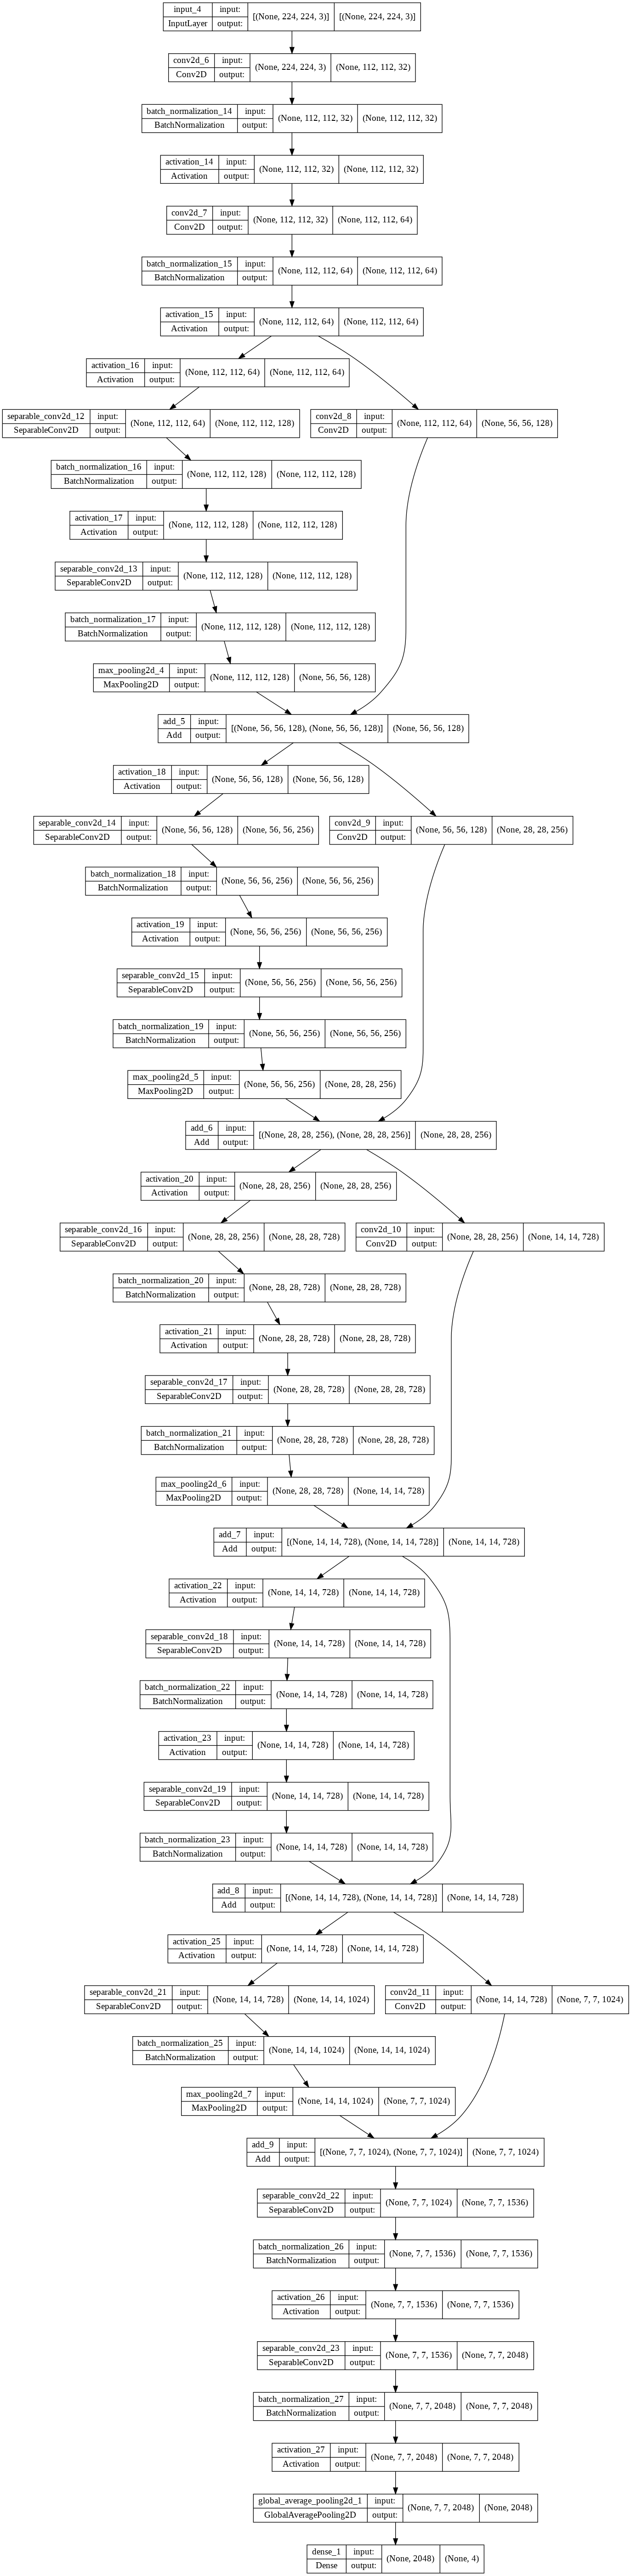

In [25]:
# plot the model architecture using plot_model function 

plot_model(xception, to_file='model.png', show_shapes=True, show_layer_names=True)


In [15]:

#part -2 Ftting the mages to the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


In [16]:

test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory(
        '/Xception/MyDrive/Classification algorithm/CNN/dataset classification/train',
        target_size=(224, 224),
        #since input size is 64x64
        batch_size=10,
        #class_mode='binary'
        )


Found 900 images belonging to 4 classes.


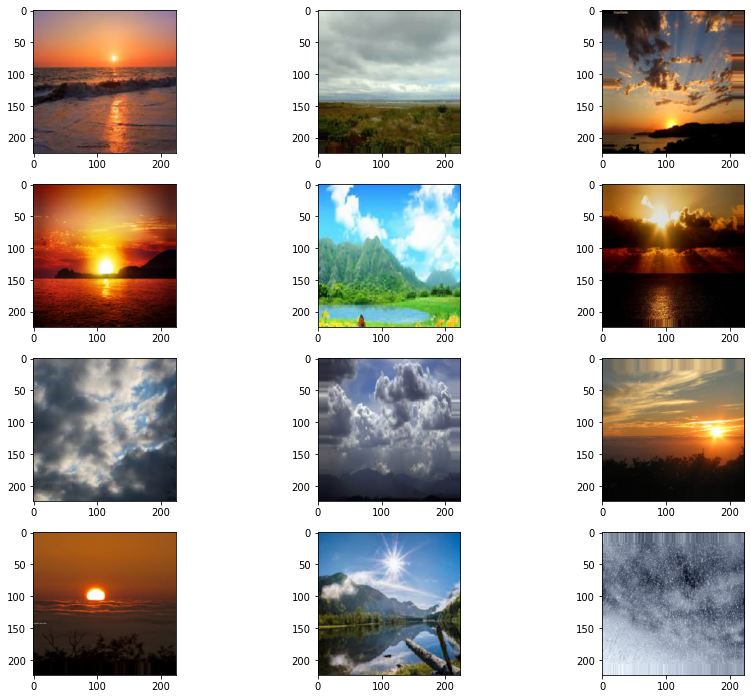

In [51]:
# Lets take a look at how augmented images from train generator look like

plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in training_set:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [17]:

test_set = test_datagen.flow_from_directory(
        '/Xception/MyDrive/Classification algorithm/CNN/dataset classification/test',
        target_size=(224, 224),
        #since input size is 64x64
        batch_size=10,
        #class_mode='binary'
        )



Found 230 images belonging to 4 classes.


In [19]:
# Saving Best model.
import os

checkpoint_path = "/Xception/MyDrive/Classification algorithm/Xception/checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [20]:
#https://www.markiiisys.com/blog/keras-modelcheckpoint-callback-yet-another-great-one/
#https://towardsdatascience.com/checkpointing-deep-learning-models-in-keras-a652570b8de6?gi=364699793ef8
import tensorflow as tf

checkpoint_callback_4  = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    #If save_weights_only is set to True, only the weights are saved, not the model topology.  
    #If set to False, it saves the weights as well as the model topology.
    save_weights_only=True,
    monitor='val_accuracy',     # monitor="loss",
    #If the value is set to True and you specify it to monitor loss, it will check the loss after every epoch
    #If the loss went down, then it will save that model.  If it didn't go down, it won't save it.
    save_best_only=True,
    # I'll share a secret.  You can use auto and Keras is smart enough to know that with loss, 
    #it should use min and with accuracy it should use max.
    mode="auto",
    #I am using epoch so it saves the model after every epoch,
    save_freq="epoch")


In [ ]:
# xception.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])
# xception.summary()


In [22]:

#error : WARNING:tensorflow:Your input ran out of data; interrupting training
#https://github.com/fizyr/keras-retinanet/issues/1449
history =xception.fit_generator(
        training_set,
        #https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch
        steps_per_epoch=90,
        #not samples_per_epoch=8000
        #steps_per_epoch=8000,
        
        epochs=25,
        #not nb_epoch=130,
        validation_data=test_set,
        validation_steps=23,
        callbacks=[checkpoint_callback_4]
        )
        #we dont use  nb_val_samples=800
        #since test_set has 2000 images



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
90/90 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.7300
Epoch 1: val_accuracy improved from -inf to 0.26957, saving model to /Xception/MyDrive/Classification algorithm/Xception/checkpoints/cp-0001.ckpt
90/90 [==============================] - 680s 7s/step - loss: 0.3342 - accuracy: 0.7300 - val_loss: 0.6539 - val_accuracy: 0.2696
Epoch 2/25
90/90 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.8211
Epoch 2: val_accuracy did not improve from 0.26957
90/90 [==============================] - 20s 225ms/step - loss: 0.2383 - accuracy: 0.8211 - val_loss: 0.6018 - val_accuracy: 0.2696
Epoch 3/25
90/90 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.8433
Epoch 3: val_accuracy improved from 0.26957 to 0.36522, saving model to /Xception/MyDrive/Classification algorithm/Xception/checkpoints/cp-0003.ckpt
90/90 [==============================] - 22s 241ms/step - loss: 0.2124 - accuracy: 0.8433 - val_loss: 0.5404 -

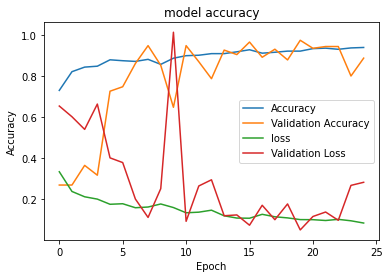

In [26]:

#import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()


In [28]:

import pandas as pd

metrics_df = pd.DataFrame(history.history)
#metrics_df

In [29]:

metrics_df.columns


Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')

In [31]:

loss, accuracy = xception.evaluate(test_set)
print('Accuracy on test dataset:', accuracy)


23/23 [==============================] - 1s 44ms/step - loss: 0.2829 - accuracy: 0.8870
Accuracy on test dataset: 0.886956512928009


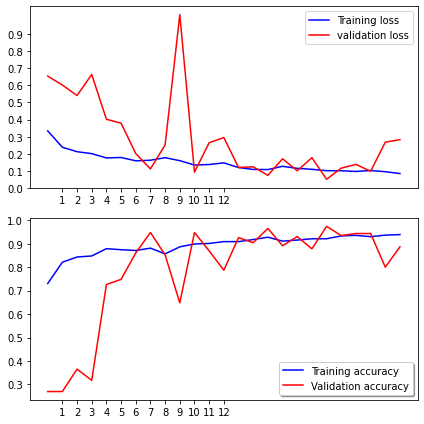

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 13, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 13, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

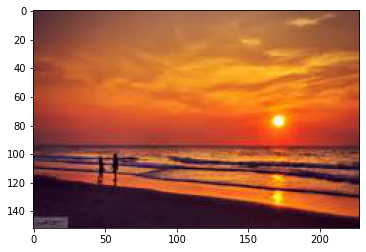

In [37]:

img_path="/Xception/MyDrive/Classification algorithm/CNN/dataset classification/test/sunrise/sunrise327.jpg"
test_image_orginal = image.load_img(img_path)
plt.imshow(test_image_orginal)


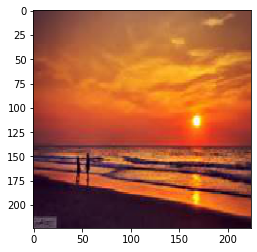

In [38]:


test_image = image.load_img(img_path, target_size=(224, 224))
plt.imshow(test_image)


In [39]:


test_image = image.img_to_array(test_image)
test_image.shape


(224, 224, 3)

In [40]:


test_image = np.expand_dims(test_image, axis=0)
test_image.shape


(1, 224, 224, 3)

In [41]:

test_set.class_indices.items()


dict_items([('cloudy', 0), ('rain', 1), ('shine', 2), ('sunrise', 3)])

In [43]:


prediction = xception.predict(test_image)
prediction


array([[0., 0., 0., 1.]], dtype=float32)

**Prediction**

------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction is :       sunrise
------------------------------------------------------------------------------------------------------------------------------------------------------


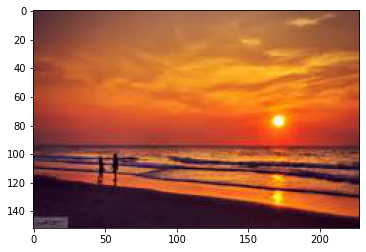

In [45]:


prediction = xception.predict(test_image)
if(prediction[0][0]==1):
  print(f"-"*100)
  print("Prediction is :       cloudy")
  print(f"-"*150)
elif(prediction[0][1]==1):
  print(f"-"*150)
  print("Prediction is :       rain")
  print(f"-"*150)
elif(prediction[0][2]==1):
  print(f"-"*150)
  print("Prediction is :       shine")
  print(f"-"*150)
elif(prediction[0][3]==1):
  print(f"-"*150)
  print("Prediction is :       sunrise")
  print(f"-"*150)

plt.imshow(test_image_orginal)
plt.show()


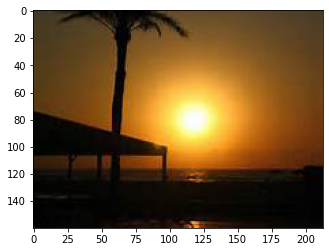

In [46]:
img_path="/Xception/MyDrive/Classification algorithm/CNN/dataset classification/test/sunrise/sunrise332.jpg"
test_image_orginal = image.load_img(img_path)
plt.imshow(test_image_orginal)

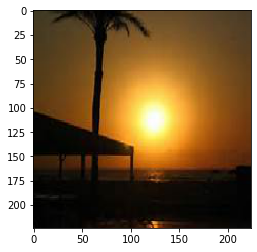

In [47]:


test_image = image.load_img(img_path, target_size=(224, 224))
plt.imshow(test_image)


In [48]:

test_image = image.img_to_array(test_image)
test_image.shape


(224, 224, 3)

In [49]:

test_image = np.expand_dims(test_image, axis=0)
test_image.shape


(1, 224, 224, 3)

------------------------------------------------------------------------------------------------------------------------------------------------------
Prediction is :       sunrise
------------------------------------------------------------------------------------------------------------------------------------------------------


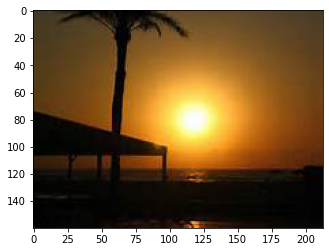

In [50]:


prediction = xception.predict(test_image)
if(prediction[0][0]==1):
  print(f"-"*100)
  print("Prediction is :       cloudy")
  print(f"-"*150)
elif(prediction[0][1]==1):
  print(f"-"*150)
  print("Prediction is :       rain")
  print(f"-"*150)
elif(prediction[0][2]==1):
  print(f"-"*150)
  print("Prediction is :       shine")
  print(f"-"*150)
elif(prediction[0][3]==1):
  print(f"-"*150)
  print("Prediction is :       sunrise")
  print(f"-"*150)

plt.imshow(test_image_orginal)
plt.show()
